C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training L1 Regularization...
Training L2 Regularization...
Training Dropout...
Training Batch Normalization...
Training L1 + Dropout...
Training L2 + Dropout...
Training Batch Norm + Dropout...


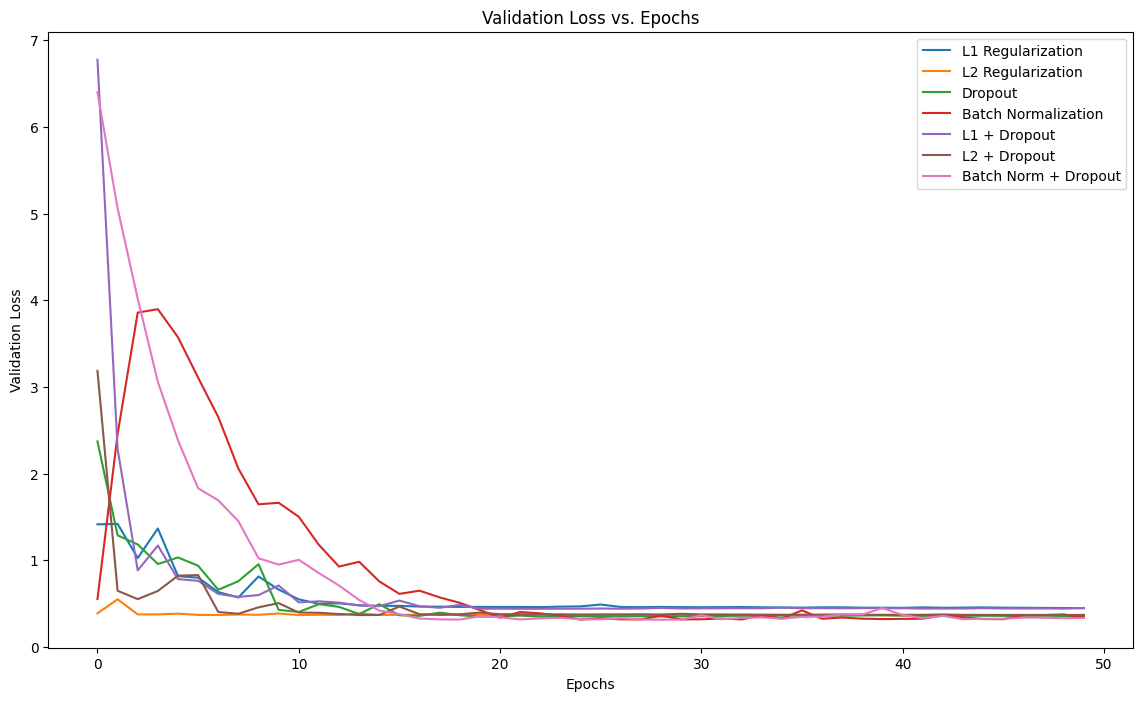

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Load dataset
df = pd.read_csv('tsp.csv')
df.columns = ['lat', 'lon', 'city', 'extra']
df.drop(columns=['extra'], inplace=True)

# Generate synthetic binary target based on distance from target location
target_lat, target_lon = 16.1067, 80.8326
df['distance'] = np.sqrt((df['lat'] - target_lat) ** 2 + (df['lon'] - target_lon) ** 2)
df['target'] = (df['distance'] < df['distance'].median()).astype(int)

# Prepare input and target variables
X = df[['lat', 'lon']]
y = df['target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create a model
def create_model(regularization=None, dropout_rate=0, batch_norm=False):
    model = Sequential()
    if regularization:
        model.add(Dense(64, input_dim=2, activation='relu', kernel_regularizer=regularization))
    else:
        model.add(Dense(64, input_dim=2, activation='relu'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train models with different regularization techniques
models = {
    "L1 Regularization": create_model(regularization='l1', dropout_rate=0.5),
    "L2 Regularization": create_model(regularization='l2', dropout_rate=0.5),
    "Dropout": create_model(dropout_rate=0.5),
    "Batch Normalization": create_model(batch_norm=True),
    "L1 + Dropout": create_model(regularization='l1', dropout_rate=0.5),
    "L2 + Dropout": create_model(regularization='l2', dropout_rate=0.5),
    "Batch Norm + Dropout": create_model(batch_norm=True, dropout_rate=0.5),
}

history = {}
for name, model in models.items():
    print(f"Training {name}...")
    history[name] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

# Plot the results
plt.figure(figsize=(14, 8))
for name, hist in history.items():
    plt.plot(hist.history['val_loss'], label=name)

plt.title('Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()
